In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import pandas as pd
import xarray as xr 
np.warnings.filterwarnings('ignore')
import cartopy.feature as cf
import cartopy.crs as ccrs

import os
import datetime

from split_filename import *
from nigthshade import *
from GOLD import *

In [2]:
class GOLD:
    
    def __init__(self, filename, infile = None):
        
        self.infile = infile 
        self.filename = filename
        
        rank = split_filename(self.filename)


        self.dataset = xr.open_dataset(self.infile + self.filename)
        
        if rank.product == 'LIM':
            self.dims = ['n_lat', 'n_alt']
            
            self.dataset.coords['n_alt'] = self.dataset['GRID_ALT'].values
            self.dataset.coords['n_lat'] = self.dataset['GRID_LAT'].values

        else:
            self.dims = ['n_ns', 'n_ew']
        
        self.dataset.coords['n_wavelength'] = self.dataset['WAVELENGTH'].mean(dim = self.dims)
    
    def dataset(self):
        return self.dataset
        
    def maximum_value(self, parameter = 'RADIANCE'):

        radiance_avg = self.dataset[parameter].mean(dim = self.dims).values

        wavelength_avg = self.dataset['WAVELENGTH'].mean(dim = self.dims).values
        
        argmax = wavelength_avg[np.argmax(radiance_avg)]

        return self.dataset.sel(n_wavelength = argmax)
        
    
    def get_1356(self):
        """
        1356 brightness map (in Rayleighs) integrates the signal from 133 to 137 nm
        """
        arr = self.dataset['n_wavelength'].values
        
        cond = (arr > 133) & (arr < 137)
        
        result_1356 = np.where(cond, arr, np.nan)
        
        result_1356 = result_1356[~np.isnan(result_1356)]

        return self.dataset.sel(n_wavelength = result_1356)

    
    def get_LBH(self, band = 'total'):
        """
        Individual files:
            Total LBH brightness map (in Rayleighs) integrates the signal from 137 to 155 nm
            with 148.5 to 150.0 nm masked;
        Combined files:
            LBH band 1 brightness map (in Rayleighs) integrates the signal from 140 to 148 nm; 
            LBH band 2 brightness map (in Rayleighs) integrates the signal from 150 to 160 nm. 
        """
        wavelength_values = self.dataset['n_wavelength'].values
        
        if band == 'total':
            start, end = 137, 155
        elif band == 1:
            start, end = 140, 148
        else:
            start, end = 150, 160
        
        cond = (wavelength_values > start) & (wavelength_values < end)
        
        result_LHB = np.where(cond, wavelength_values, np.nan)
        
        result_LHB = result_LHB[~np.isnan(result_LHB)]

        return self.dataset.sel(n_wavelength = result_LHB)
    
    def get_atributes(self):
    
        mirror = self.dataset.attrs['MIRROR_HEMISPHERE']

        if mirror == 'S':
            self.mirror = 'South'
        else:
            self.mirror = 'North'

        self.time_start = pd.to_datetime(self.dataset.attrs['DATE_START']).strftime("%H:%M")

        channel = self.dataset.attrs['INSTRUMENT']

        if channel == 'CHB':
            self.channel = 'Channel B'
        else:
            self.channel = 'Channel A'

        return list((self.mirror, self.time_start, self.channel))
    

In [3]:
infile = 'C:\\Users\\Luiz Felipe\\Downloads\\DAY2019111120191112\\tmp\\archive_L1C\\2019\\315\\'


_, _, files  = next(os.walk(infile))

rad = []
times = []

for i in range(len(files)):
    
    ds = GOLD(files[i], infile)  
    data = ds.dataset.mean(dim = ['n_ns', 'n_ew'])
    
    times.append(split_filename(files[i]).datetime)
    rad.append(data['RADIANCE'].values)



In [41]:

wave_cont = ds.dataset.coords['n_wavelength'].values

dat =  np.log10(np.vstack(rad))

dat[dat < 0] = np.nan

ds.dataset

<xarray.Dataset>
Dimensions:                         (n_ew: 92, n_ns: 104, n_wavelength: 800)
Coordinates:
  * n_wavelength                    (n_wavelength) float32 132.74854 ... 164.76953
Dimensions without coordinates: n_ew, n_ns
Data variables:
    GRID_EW                         (n_ew) float32 -9.099999 -8.9 ... 9.1
    GRID_NS                         (n_ns) float32 -10.299999 ... 10.3
    GRID_LAT                        (n_ns, n_ew) float32 nan nan nan ... nan nan
    GRID_LON                        (n_ns, n_ew) float32 nan nan nan ... nan nan
    TIME_ET                         (n_ns, n_ew) float64 6.268e+08 ... nan
    TIME_UTC                        (n_ns, n_ew) |S24 ...
    L1B_TIME_BINS_PER_GRID          (n_ns, n_ew) uint16 4 4 4 4 4 ... 0 0 0 0 0
    L1B_PIXELS_PER_GRID             (n_ns, n_ew) uint16 32 36 36 36 ... 0 0 0 0
    QUALITY_FLAG                    (n_ns, n_ew) uint32 0 0 0 0 0 ... 0 0 0 0 0
    WAVELENGTH                      (n_ns, n_ew, n_wavelength) float32 132.74321 ... nan
    RAW_COUNT                       (n_ns, n_ew, n_wavelength) float32 0.0 ... nan
    RAW_COUNT_RANDOM_UNC            (n_ns, n_ew, n_wavelength) float32 0.0 ... nan
    CORRECTED_COUNT                 (n_ns, n_ew, n_wavelength) float32 -0.095236205 ... nan
    CORRECTED_COUNT_SYSTEMATIC_UNC  (n_ns, n_ew, n_wavelength) float32 0.0 ... nan
    CORRECTED_COUNT_RANDOM_UNC      (n_ns, n_ew, n_wavelength) float32 0.0 ... nan
    RADIANCE                        (n_ns, n_ew, n_wavelength) float32 -3.081789 ... nan
    RADIANCE_SYSTEMATIC_UNC         (n_ns, n_ew, n_wavelength) float32 0.46226838 ... nan
    RADIANCE_RANDOM_UNC             (n_ns, n_ew, n_wavelength) float32 0.0 ... nan
    BACKGROUND_COUNTS               (n_ns, n_ew, n_wavelength) float32 0.095236205 ... nan
    REFERENCE_POINT_LAT             (n_ns, n_ew) float32 -46.96798 ... nan
    REFERENCE_POINT_LON             (n_ns, n_ew) float32 -117.26423 ... nan
    TANGENT_HEIGHT                  (n_ns, n_ew) float32 3587.5676 ... nan
    RAY_SOLAR_PHASE_ANGLE           (n_ns, n_ew) float32 47.4763 ... nan
    RAY_NADIR_ANGLE                 (n_ns, n_ew) float32 13.649619 ... nan
    EMISSION_ANGLE                  (n_ns, n_ew) float32 90.0499 ... nan
    SOLAR_ZENITH_ANGLE              (n_ns, n_ew) float32 52.062824 ... nan
Attributes:
    _NCPROPERTIES:               [118 101 114 115 105 111 110  61  49 124 110...
    ACKNOWLEDGEMENT:             This is a data product from the NASA Global-...
    ADID_REF:                    NASA Contract > NNG12PQ28C
    CONVENTIONS:                 SPDF ISTP/IACF Modified for NetCDF
    DATA_LEVEL:                  L1C
    DATA_TYPE:                   APIDx0F > GOLD Application ID 0x0F: Level 1C...
    OBSERVATION_TYPE:            DAY_DISK
    OBS_TYPE:                    1
    OBS_ID:                      1942
    CHANNEL_ID:                  0
    DATA_VERSION:                2
    DATA_REVISION:               1
    DATA_CYCLE:                  1
    TC_VER:                      3
    GC_VER:                      3
    OC_VER:                      1
    MINIMUM_PHD:                 10
    MAXIMUM_PHD:                 254
    SPATIAL_BINNING:             3
    SPECTRAL_BINNING:            2
    SLIT_NAME:                   HI_RES
    GYM_POSITION:                218.0
    MIRROR_HEMISPHERE:           S
    REFERENCE_ALTITUDE:          150.0
    SC_REF_ALTITUDE:             35785.9
    SC_REF_LON:                  -47.5
    SC_ALT:                      35792.93
    SC_ALT_MIN_MAX:              [35792.83  35792.918]
    SC_POS:                      [41179.23    -9071.222     -55.31818]
    SC_POS_X_MIN_MAX:            [40943.055 41398.184]
    SC_POS_Y_MIN_MAX:            [-10102.152  -8036.498]
    SC_POS_Z_MIN_MAX:            [-55.45674  -55.156322]
    SC_Z_DIR:                    [-0.97647786  0.21512203  0.00121184]
    SC_Z_DIR_X_MIN_MAX:          [-0.9816693  -0.97088027]
    SC_Z_DIR_Y_MIN_MAX:          [0.19058825 0.23956221]
   

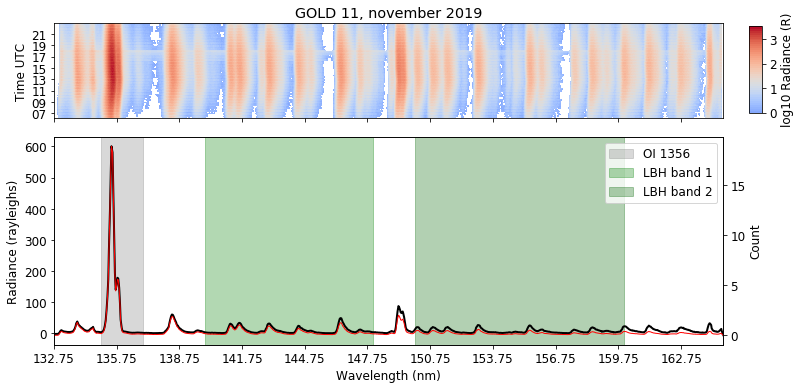

In [29]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 8))

G = gridspec.GridSpec(4, 3)

ax2 = plt.subplot(G[1:3, :])

data['RADIANCE'].plot(ax = ax2, color = 'black', lw = 2)

ax11 = ax2.twinx()

data['CORRECTED_COUNT'].plot(ax = ax11, color = 'red', lw = 1)

ax11.set(ylabel = 'Count')

wavelength = [(135, 137), (140, 148), (150, 160)]

colors = ['grey', 'green', 'darkgreen']

labels = ['OI 1356', 'LBH band 1', 'LBH band 2']

for wave, color, label in zip(wavelength, colors, labels):
    
    ax2.axvspan(wave[0], wave[1],  color = color, alpha=0.3, label = label)

ax2.legend()

ax2.set(ylabel = 'Radiance (rayleighs)', xlabel = 'Wavelength (nm)', 
        xticks = np.arange(min(wave_cont), max(wave_cont), 3))

ax1 = plt.subplot(G[0, :], sharex=ax2)

img = ax1.contourf(wave_cont, times, dat, 45, vmin = -1, cmap = 'coolwarm')

ax1.yaxis.set_major_formatter(dates.DateFormatter('%H'))
ax1.yaxis.set_major_locator(dates.HourLocator(interval = 2))

cbar_ax = fig.add_axes([.93, 0.725, 0.015, 0.15])

cb = fig.colorbar(img, ticks = np.arange(0, 5, 1), cax = cbar_ax)

cb.set_label('log10 Radiance (R)')

ax1.set(ylabel = 'Time UTC', title = 'GOLD 11, november 2019')

plt.setp(ax1.get_xticklabels(), visible=False)

plt.rcParams.update({'font.size': 12}) 


plt.show()

In [40]:
def figure_name(files, emission):
    
    emission = emission.replace(' ', '_').upper()
    
    if isinstance(files, list):
        
        if len(files) == 2:
            first, second = files[0], files[1]
        else:
            first, second = files[0], files[-1]
            
        start = split_filename(first)
        end = split_filename(second)
        time_start, time_end = start.time().replace(':',''), end.time().replace(':','')
        date = str(start.date(extent = False)).replace('-', '_')
        
        return f"GOLD_{start.product}_{emission}_{date}_{time_start}_{time_end}"
    else:
        start = split_filename(filename)
        if start.level == 'L2':
             return f"GOLD_{emission.upper()}_{start.level}_{str(start.date(extent = False)).replace('-', '_')}"
        


FigureName = figure_name(files, 'Radiance spectro')
PathOut = 'C:\\Users\\Luiz Felipe\\Google Drive\\Doutorado\\Modelos_Latex_INPE\\Figuras1\\'

fig.savefig(PathOut + FigureName + '.png', dpi = 100, quality = 95, bbox_inches="tight")


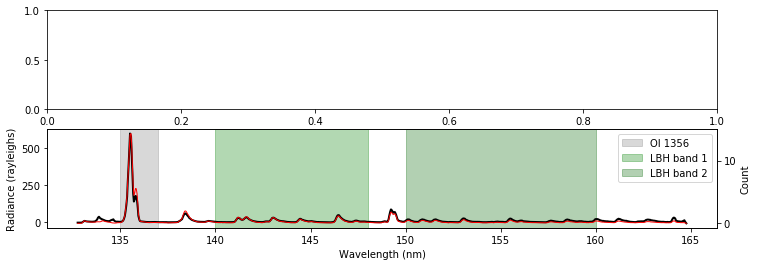

In [48]:
fig, ax = plt.subplots(figsize = (12,  4), nrows = 2)

data['RADIANCE'].plot(ax = ax[1], color = 'black', lw = 2)

ax1 = ax[1].twinx()

data['RAW_COUNT'].plot(ax = ax1, color = 'red', lw = 1)

ax1.set(ylabel = 'Count')

wavelength = [(135, 137), (140, 148), (150, 160)]

colors = ['grey', 'green', 'darkgreen']

labels = ['OI 1356', 'LBH band 1', 'LBH band 2']

for wave, color, label in zip(wavelength, colors, labels):
    
    ax[1].axvspan(wave[0], wave[1],  color = color, alpha=0.3, label = label)

ax[1].legend()

ax[1].set(ylabel = 'Radiance (rayleighs)', xlabel = 'Wavelength (nm)')

plt.rcParams.update({'font.size': 14}) 


plt.show()